# Bias Detection in News Headlines: Emotion, Leaning & Interpretability

This notebook explores rhetorical bias in news headlines by analyzing emotional framing, political leaning and lexical politicization through a structured, multi-stage NLP pipeline.

To assess model performance and explore whether auxiliary features such as emotion and political orientation enhance bias classification, we trained two variants of `microsoft/deberta-v3-base`: a **text-only baseline** and a **feature-enhanced model** integrating contextual signals.

Emotion, political leaning, and politicization were classified at both word and document level to extract interpretable features. We then examined linear and non-linear correlations to uncover structural patterns of bias across headlines.

Both models were evaluated using **Stratified K-Fold Cross Validation** to ensure balanced class representation and mitigate the effects of class imbalance.

The pipeline is modular, reproducible, and designed to support both statistical insight and downstream interpretability in bias-aware modeling.

## 1 Library imports and initialization

In [ ]:
# Core libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# NLP and Transformers
import torch
import gc
from huggingface_hub import login
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    Trainer,
    TrainingArguments,
    set_seed,
    DataCollatorWithPadding,
    RobertaTokenizer,
    DebertaV2Tokenizer,
    DebertaV2ForSequenceClassification,
    TextClassificationPipeline
)
from datasets import load_dataset, Dataset, DatasetDict
import torch.nn.functional as F

# Statistical analysis
from scipy.stats import chi2_contingency

# Evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Linguistic analysis (optional)
import spacy
nlp = spacy.load("en_core_web_sm")

# Colab integration and file handling
from google.colab import files
import pickle

## 2. Data import

In this section, we loaded the MBIC dataset (1,700 headlines) and the BEADs dataset (42,599 headlines), and created a subset with the relevant columns "text" and "label".

To simplify downstream modeling and evaluation, we dropped any rows with missing values in these columns and converted the original **bias labels into a binary format**:

- `biased` → `1`  
- `unbiased` → `0`

### Load MBIC dataset

In [ ]:
import kagglehub
path = kagglehub.dataset_download("timospinde/mbic-a-media-bias-annotation-dataset")
df = pd.read_excel(os.path.join(path, "labeled_dataset.xlsx"))

Using Colab cache for faster access to the 'mbic-a-media-bias-annotation-dataset' dataset.


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
# Select relevant columns
df_mbic = df[["sentence", "Label_bias"]].copy()

In [ ]:
# Convert bias labels into a binary format
df_mbic["bias_binary"] = df_mbic["Label_bias"].apply(lambda x: 1 if x.lower() == "biased" else 0)

In [ ]:
# Preparation of merge with BEADs Dataset: majority voting on bias label
df_mbic = df_mbic.groupby("sentence")["bias_binary"].agg(lambda x: x.value_counts().idxmax()).reset_index()

In [ ]:
len(df_mbic)

1700

### Load BEADs dataset text classification subset

In [ ]:
# Token for Huggingface access to dataset
login(os.getenv("HF_Token"))
beads = load_dataset("csv", data_files={
    "train": "hf://datasets/shainar/BEAD/1-Text-Classification/bias-train.csv",
    "validation": "hf://datasets/shainar/BEAD/1-Text-Classification/bias-valid.csv"
})

bias-train.csv:   0%|          | 0.00/8.37M [00:00<?, ?B/s]

bias-valid.csv:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
# Convert to dataframes
df_train = pd.DataFrame(beads["train"])
df_valid = pd.DataFrame(beads["validation"])

# Check columns and standardize
df_train = df_train[["text", "label"]]
df_valid = df_valid[["text", "label"]]

# Merge dataset
df_beads = pd.concat([df_train, df_valid], ignore_index=True)
df_beads.columns = ["text", "bias_binary"]

In [ ]:
len(df_beads)

42599

In [ ]:
# Merge of MBIC and BEADS
df_mbic.columns = ["text", "bias_binary"]
df_beads = df_beads[["text", "bias_binary"]].copy()
df_combined = pd.concat([df_mbic, df_beads], ignore_index=True)

In [ ]:
overlap = set(df_mbic["text"]).intersection(set(df_beads["text"]))
print(f"Number of overlapping headlines between datasets: {len(overlap)}")

Number of overlapping headlines between datasets: 0


In [ ]:
df_combined = df_combined.dropna(subset=["text", "bias_binary"])
len(df_combined)

44299

## 3. Explorative data analysis (EDA)
In this section, we explored the distribution of bias labels and the headline length to gain insight into the structure of the dataset, identify patterns as well as possible influences on model performance.

### 3.1 Spread of bias labels
First, the distribution of bias labels is shown in the bar graph below. It shows the frequency of each label category (`biased` → `1`, `unbiased` → `0`), helping to assess class balance and potential imbalances.

The bar graph revealed a slight **class imbalance** in the dataset, with more headlines labeled as "biased" (31,919) than "non-biased" (28,455).

While the label distribution in the merged dataset is relatively balanced, we still applied stratified sampling for model trainings and evaluated performance using macro-F1 to ensure robustness across both bias classes.

In [ ]:
# Count biased vs nonbiased labels in dataset
df_combined["bias_binary"].value_counts()

,count
bias_binary,
1,31919
0,28455


<Axes: title={'center': 'Distribution of Bias Labels'}, xlabel='bias_binary'>

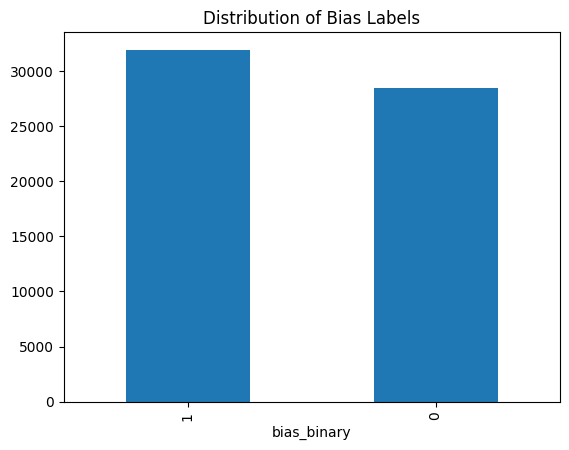

In [ ]:
# Plot of count biased vs. non-biased
df_combined["bias_binary"].value_counts().plot(kind="bar", title="Distribution of Bias Labels")

### 3.2 Headline length

Additionally, we examined the distribution of headline lengths by counting the number of words in each entry. This provides insight into the structural characteristics of the dataset's textual input, which consists of short, compact headlines. Such shortness is typical of news headlines, where rhetorical density and emotional framing are often concentrated into just a few words.

The distribution of headline lengths reveals a strong skew toward short texts, with the majority falling **below 100 characters**. This supports the use of compact transformer input windows and minimizes the risk of truncation during tokenization.

<Axes: title={'center': 'Distribution of Headline Lengths'}, ylabel='Frequency'>

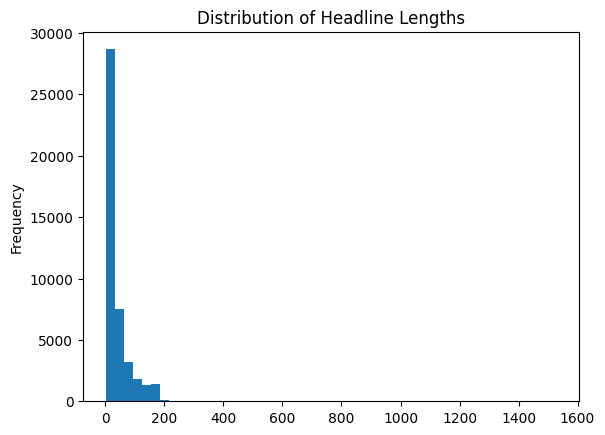

In [ ]:
# Headline length (count and plot)
df_combined["text_length"] = df_combined["text"].apply(lambda x: len(str(x).split()))
df_combined["text_length"].plot(kind="hist", bins=50, title="Distribution of Headline Lengths")

### Modeling insights from EDA

The merged dataset reveals two key characteristics relevant for bias classification:

- **Slight label imbalance** (≈ 53% biased vs. 47% non-biased), which motivates the use of macro-F1 and stratified sampling to ensure fair evaluation.
- **Short headline structure**, with most texts under 100 characters, enables transformer-based modeling of emotionally charged bias cues.

These insights informed our modeling choices and supported the use of short input sequences and balanced evaluation metrics.

## 4. Baseline Model: Text-Only Bias Classification (DeBERTa-v3)

To evaluate the impact of engineered features (emotion and POS), we first trained a baseline model using `microsoft/deberta-v3-base`. We used the `text` column from the combined dataset as input and the `bias_binary` column for the label prediction.

This baseline helped to enable a direct comparison with our feature-enhanced model to answer the question, to what extend additional features like emotional tone and political leaning can enhance the detection of rhetorical bias.

The text-only model was trained using stratified k-fold cross validation and evaluated with standard metrics:

- Accuracy  
- F1 Score (macro)
- Precision
- Recall

This provided a transparent benchmark for understanding how much engineered features contributed to bias detection.


### 4.1 Text-only model training

In [ ]:
# Select balanced dataset
texts = df_combined["text"].tolist()
labels = df_combined["bias_binary"].tolist()

In [ ]:
# Stratified K-Fold setup
set_seed(42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-base")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

In [ ]:
# Metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = np.argmax(probs, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro")
    }

In [ ]:
def tokenize_function(examples):
    tokens = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)
    tokens["labels"] = examples["label"]
    return tokens

In [ ]:
# Cross-validation loop
all_metrics = []
all_preds = []

def tokenize_function(examples):
    tokens = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokens["labels"] = examples["label"]
    return tokens

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels), start=1):
    print(f"\n===== Fold {fold} =====")

    # Split data
    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    # Datasets
    train_dataset = Dataset.from_dict({
        "text": train_texts,
        "label": train_labels
    }).map(tokenize_function, batched=True)

    val_dataset = Dataset.from_dict({
         "text": val_texts,
         "label": val_labels
    }).map(tokenize_function, batched=True)


    # Model
    model = DebertaV2ForSequenceClassification.from_pretrained(
        "microsoft/deberta-v3-base",
        num_labels=2
    )


    # Training setup
    output_dir = f"./results/fold{fold}"
    os.makedirs(output_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        eval_strategy="epoch",
        logging_dir=f"./logs/fold{fold}",
        logging_steps=10,
        save_strategy="epoch",
        save_total_limit=2,
        learning_rate=1e-5,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none"
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )

    # Train and evaluate
    trainer.train()
    metrics = trainer.evaluate()
    print(f"\nFold {fold} metrics:")
    print(metrics)
    all_metrics.append(metrics)

    # Save metrics for this fold
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(f"{output_dir}/metrics.csv", index=False)

    # Predictions
    preds_output = trainer.predict(val_dataset)
    logits = preds_output.predictions
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = np.argmax(logits, axis=-1)

    fold_df = pd.DataFrame({
        "text": val_texts,
        "true_label": val_labels,
        "predicted_label": preds.tolist(),
        "probabilities": probs.tolist()
    })
    fold_df.to_csv(f"{output_dir}/predictions.csv", index=False)
    all_preds.append(fold_df)


===== Fold 1 =====


Map:   0%|          | 0/35439 [00:00<?, ? examples/s]

Map:   0%|          | 0/8860 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-862043436.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.486800,0.437401,0.815124,0.814955,0.815505,0.817047
2,0.389900,0.419637,0.830361,0.830277,0.830664,0.831613
3,0.400600,0.489533,0.832731,0.832729,0.832780,0.832750



Fold 1 metrics:
{'eval_loss': 0.48953330516815186, 'eval_accuracy': 0.8327313769751693, 'eval_f1': 0.8327294592139742, 'eval_recall': 0.8327799001211029, 'eval_precision': 0.8327503946046778, 'eval_runtime': 86.4428, 'eval_samples_per_second': 102.496, 'eval_steps_per_second': 12.818, 'epoch': 3.0}

===== Fold 2 =====


Map:   0%|          | 0/35439 [00:00<?, ? examples/s]

Map:   0%|          | 0/8860 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-862043436.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.392300,0.415886,0.820429,0.820333,0.820731,0.821709
2,0.388000,0.397656,0.837020,0.837019,0.837125,0.837171
3,0.399000,0.463401,0.837923,0.837914,0.838077,0.838257



Fold 2 metrics:
{'eval_loss': 0.46340084075927734, 'eval_accuracy': 0.837923250564334, 'eval_f1': 0.8379137029101072, 'eval_recall': 0.8380767088665264, 'eval_precision': 0.8382572225712897, 'eval_runtime': 85.755, 'eval_samples_per_second': 103.318, 'eval_steps_per_second': 12.921, 'epoch': 3.0}

===== Fold 3 =====


Map:   0%|          | 0/35439 [00:00<?, ? examples/s]

Map:   0%|          | 0/8860 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-862043436.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.595400,0.427195,0.820542,0.820454,0.820834,0.821740
2,0.372600,0.457455,0.832506,0.832404,0.832345,0.832833
3,0.319100,0.476136,0.835327,0.835288,0.835556,0.836079



Fold 3 metrics:
{'eval_loss': 0.4761364459991455, 'eval_accuracy': 0.8353273137697517, 'eval_f1': 0.8352879316479205, 'eval_recall': 0.8355561273320851, 'eval_precision': 0.8360793671047595, 'eval_runtime': 85.9163, 'eval_samples_per_second': 103.124, 'eval_steps_per_second': 12.896, 'epoch': 3.0}

===== Fold 4 =====


Map:   0%|          | 0/35439 [00:00<?, ? examples/s]

Map:   0%|          | 0/8860 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-862043436.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.359100,0.408082,0.824831,0.824691,0.825182,0.826580
2,0.317500,0.423746,0.830361,0.829985,0.829983,0.832320
3,0.347700,0.472334,0.837133,0.837132,0.837237,0.837280



Fold 4 metrics:
{'eval_loss': 0.47233402729034424, 'eval_accuracy': 0.8371331828442438, 'eval_f1': 0.8371320852956337, 'eval_recall': 0.8372372624420127, 'eval_precision': 0.8372803526752367, 'eval_runtime': 86.2913, 'eval_samples_per_second': 102.675, 'eval_steps_per_second': 12.84, 'epoch': 3.0}

===== Fold 5 =====


Map:   0%|          | 0/35440 [00:00<?, ? examples/s]

Map:   0%|          | 0/8859 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-862043436.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.431500,0.441153,0.818264,0.818261,0.818379,0.818444
2,0.302900,0.414032,0.833051,0.833020,0.832998,0.833066
3,0.389100,0.467883,0.834293,0.834271,0.834485,0.834809



Fold 5 metrics:
{'eval_loss': 0.46788322925567627, 'eval_accuracy': 0.8342928095721864, 'eval_f1': 0.8342712683097901, 'eval_recall': 0.834485251683379, 'eval_precision': 0.8348092995822871, 'eval_runtime': 86.3598, 'eval_samples_per_second': 102.582, 'eval_steps_per_second': 12.83, 'epoch': 3.0}


In [ ]:
# Save all metrics across folds
all_metrics_df = pd.DataFrame(all_metrics)
all_metrics_df.to_csv("./results/all_fold_metrics_nofeatures.csv", index=False)

# Combine all predictions
all_preds_df = pd.concat(all_preds, ignore_index=True)
all_preds_df.to_csv("./results/all_predictions_nofeatures.csv", index=False)

### 4.2 Evaluation of text-only model

The **text-only model** showed consistently strong performance across all five folds. Each fold was trained for three epochs using the `microsoft/deberta-v3-base` model, with newly initialized classification layers. The model relied solely on headline text, without incorporating auxiliary features.

Across folds, accuracy remained stable between 82-84%, with macro F1, precision, and recall values closely aligned. Validation loss fluctuated only slightly (between 0.41 and 0.49), indicating robust convergence and minimal overfitting.

The low variance across folds confirmed that the **model generalizes well from short-form input**. Its ability to maintain high predictive performance without auxiliary signals highlights the strength of transformer-based representations for headline-level bias classification.






## 5. Emotion Detection
Following the training of our baseline model, we turned to the emotional tone embedded in the headlines. To quantify this emotional dimension, we used the transformer-based model `j-hartmann/emotion-english-distilroberta-base`, which is fine-tuned for emotion classification in English text.

It outputs scores across seven emotion categories: **anger**, **disgust**, **fear**, **joy**, **neutral**, **sadness**, and **surprise**.

Emotion scores were extracted in batch mode for efficiency and converted into a structured DataFrame. Each headline was assigned a dominant emotion label based on the highest score across seven categories and saved in a new column `dominant_emotion`.

In [ ]:
emotion_model_name = "j-hartmann/emotion-english-distilroberta-base"
emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_model_name)
emotion_model = AutoModelForSequenceClassification.from_pretrained(emotion_model_name).to("cuda")

# Prepare texts
texts = df_combined["text"].tolist()
batch_size = 32
emotion_outputs = []

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]

    # Tokenize with truncation and padding
    inputs = emotion_tokenizer(
        batch,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to("cuda")

    with torch.no_grad():
        logits = emotion_model(**inputs).logits
        probs = F.softmax(logits, dim=-1)

    # Convert to list of dicts with label + score
    batch_outputs = []
    for example_probs in probs:
        batch_outputs.append([
            {"label": emotion_model.config.id2label[i], "score": float(score)}
            for i, score in enumerate(example_probs)
        ])

    emotion_outputs.extend(batch_outputs)

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

  0%|          | 0/1385 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

100%|██████████| 1385/1385 [04:23<00:00,  5.26it/s]


In [ ]:
# Convert outputs to DataFrame
def scores_to_dict(score_list):
    return {item["label"]: item["score"] for item in score_list}

emotion_dicts = [scores_to_dict(entry) for entry in emotion_outputs]
emotion_df = pd.DataFrame(emotion_dicts)

# Concatenate emotion scores with df_combined
df_combined = pd.concat([df_combined.reset_index(drop=True), emotion_df.reset_index(drop=True)], axis=1)

In [ ]:
# Determine dominant emotion
df_combined["dominant_emotion"] = emotion_df.idxmax(axis=1)

### 5.1 Evaluation Emotion detection

To evaluate the model classification results, we reviewed the most frequent emotion overall in the new column `dominant_emotion` as well as the bias distribution per emotion.

While **neutral** is the most frequent dominant emotion in the dataset (14,285 headlines), it is not the most strongly associated with bias. Instead, emotions such as **joy** (83.7%) and **fear** (57.5%) show disproportionately high bias rates relative to their frequency, suggesting that affective intensity plays a more decisive role in bias perception than raw occurrence.

This pattern is further supported by elevated bias shares for **surprise** (57.4%) and **disgust** (24.2%), indicating that emotionally charged headlines may trigger stronger ideological sensitivity and contribute to perceived rhetorical bias, regardless of their prevalence.

In [ ]:
# Most frequent emotion
df_combined["dominant_emotion"].value_counts()

,count
dominant_emotion,
neutral,14285
fear,6299
sadness,5774
joy,5355
anger,5026
surprise,4658
disgust,2902


In [ ]:
# Bias distribution across emotions
emotion_bias_rate = df_combined.groupby("dominant_emotion")["bias_binary"].value_counts(normalize=True).unstack()[1]
print(emotion_bias_rate.sort_values(ascending=False))

dominant_emotion
joy         0.836788
fear        0.575329
surprise    0.574066
neutral     0.525796
sadness     0.400935
disgust     0.242247
anger       0.210505
Name: 1, dtype: float64


## 6. Political Leaning Classification

To complement the emotion detection, we estimated the ideological orientation of each headline using the transformer-based model `matous-volf/political-leaning-politics`. This model classifies text into three categories: **left**, **center**, and **right**, based on linguistic and rhetorical patterns commonly found in political discourse.

Headlines were processed in batches using a HuggingFace pipeline with `return_all_scores=True`, capturing confidence scores across all three classes. The final label was determined by selecting the class with the highest score and stored in a new column `political_leaning` for downstream analysis.

In [ ]:
political_model_name = "matous-volf/political-leaning-politics"
political_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
political_model = AutoModelForSequenceClassification.from_pretrained(political_model_name)
political_classifier = pipeline(
    "text-classification",
    model=political_model,
    tokenizer=political_tokenizer,
    return_all_scores=True,
    device=0
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/895 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Load tokenizer and model from separate repos
tokenizer = AutoTokenizer.from_pretrained("launch/POLITICS")
model = AutoModelForSequenceClassification.from_pretrained("matous-volf/political-leaning-politics").to("cuda")

# Define label mapping based on model card
label_map = {
    "LABEL_0": "left",
    "LABEL_1": "center",
    "LABEL_2": "right"
}

# Prepare texts
texts = df_combined["text"].tolist()
batch_size = 32
leaning_outputs = []

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]

    # Tokenize with truncation and padding
    inputs = tokenizer(
        batch,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to("cuda")

    with torch.no_grad():
        logits = model(**inputs).logits
        probs = F.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=1)

    # Convert to list of dicts with mapped label + score + full class scores
    for j in range(len(batch)):
        label_id = preds[j].item()
        raw_label = model.config.id2label[label_id]
        mapped_label = label_map[raw_label]
        score = probs[j, label_id].item()
        leaning_outputs.append({
            "political_leaning": mapped_label,
            "leaning_confidence": score,
            "left_score": probs[j, 0].item(),
            "center_score": probs[j, 1].item(),
            "right_score": probs[j, 2].item()
        })

# Add to combined dataframe
df_combined["political_leaning"] = [x["political_leaning"] for x in leaning_outputs]
df_combined["leaning_confidence"] = [x["leaning_confidence"] for x in leaning_outputs]
df_combined["left_score"] = [x["left_score"] for x in leaning_outputs]
df_combined["center_score"] = [x["center_score"] for x in leaning_outputs]
df_combined["right_score"] = [x["right_score"] for x in leaning_outputs]

tokenizer_config.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/895 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

100%|██████████| 1385/1385 [08:39<00:00,  2.66it/s]


### 6.1 Evaluation political leaning

For political leaning prediction, the majority of headlines were classified as **left** (n = 29,603), with **right** (n = 13,353) following behind and **center** (n = 1,343) receiving the fewest classifications. This distribution provided a contextual layer for interpreting bias predictions, showing that left-leaning headlines dominate the dataset and may influence the overall framing dynamics.

In [ ]:
# Distribution of bias types
df_combined["political_leaning"].value_counts()

,count
political_leaning,
left,29603
right,13353
center,1343


## 7. Word-Level Politicization

Finally, the word-level analysis revealed how individual terms are distributed across biased and unbiased headlines. For each word, we computed its frequency in biased vs. non-biased contexts, the dominant emotion (`dominant_emotion`), and the dominant political leaning (`political_leaning`). Words that appeared more often in biased texts were flagged as "**politicized**".



In [ ]:
word_data = []
for doc_idx, doc in enumerate(nlp.pipe(df_combined["text"], disable=["ner"])):
    for token in doc:
        if not token.is_alpha or token.is_stop:
            continue
        word_data.append({
            "word": token.text.lower(),
            "POS": token.pos_,
            "sentence_idx": doc_idx
        })

words_df = pd.DataFrame(word_data)

In [ ]:
# Merge with sentence-level emotion, political leaning
words_df = words_df.merge(
    df_combined[["dominant_emotion", "political_leaning", "bias_binary"]],
    left_on="sentence_idx",
    right_index=True,
    how="left"
)

In [ ]:
# Compute frequencies for biased/unbiased contexts
word_stats = words_df.groupby("word").agg(
    freq_biased=("bias_binary", "sum"),
    freq_unbiased=("bias_binary", lambda x: (x == 0).sum()),
    top_emotion=("dominant_emotion", lambda x: x.value_counts().idxmax()),
    leaning_shift=("political_leaning", lambda x: x.value_counts().idxmax())
).reset_index()

# Find words that appear more often in biased contexts
word_stats["politicized"] = np.where(word_stats["freq_biased"] > word_stats["freq_unbiased"], "yes", "no")

### 7.1 Document-Level Politicization Score

To quantify the presence of politically charged language at document level, we computed a politicization score for each headline. This score reflects the number of words in a headline that appear more frequently in biased contexts, based on prior word-level analysis.

Using spaCy, each headline was **tokenized and filtered for meaningful content words**. The score was then calculated by counting how many of these words are part of the previously identified set of politicized terms.

This metric provided a simple yet interpretable signal for downstream tasks such as bias classification, thresholding, or exploratory analysis of political framing intensity across topics or outlets.

In [ ]:
# Get set of politicized words
politicized_words = set(word_stats.loc[word_stats["politicized"] == "yes", "word"])

In [ ]:
# Count politicized words per document
scores = []
for doc in tqdm(nlp.pipe(texts, disable=["ner"]), total=len(texts)):
    tokens = [t.text.lower() for t in doc if t.is_alpha and not t.is_stop]
    score = sum(1 for t in tokens if t in politicized_words)
    scores.append(score)

100%|██████████| 44299/44299 [02:50<00:00, 259.65it/s]


In [ ]:
# Assign politicization score to each document based on frequency of biased words
df_combined["politicization_score"] = scores

### 7.2 Evaluation document-level politication scores
Headlines labeled as “Biased” exhibited a higher average politicization score (2.61) compared to “Non-biased” headlines (1.26). This suggests that the presence of ideologically charged language contributes to bias perception, reinforcing the link between lexical framing and annotation outcomes.

In [ ]:
# Average score per bias label
df_combined.groupby("bias_binary")["politicization_score"].mean()

,politicization_score
bias_binary,
0,1.263393
1,2.610927


In [ ]:
df_combined.to_csv("df_combined_full_features.csv", index=False, encoding="utf-8")

## 8. Correlation Analysis

In this section, we explored the relationships between key variables in the dataset to uncover potential dependencies that may inform bias classification. By examining how the features **emotional tone** and **political leaning** related to perceived bias, we aimed to identify patterns that could support feature selection and model design to provide a statistical foundation for interpreting rhetorical framing.

### 8.1 Pearsons correlation

We applied Pearson correlation, a statistical measure that captures the strength and direction of **linear relationships** between numerical variables. To enable this, categorical features like `dominant_emotion` and `political_leaning` were encoded numerically. We then computed their correlation with the binary bias label (`bias_binary`) and `politicization_score`.

The resulting correlation matrix was visualized as a heatmap:

- **Politicization vs. Bias**: A modest positive correlation (**r = 0.16**) suggesting that headlines containing more politicized vocabulary are somewhat more likely to be labeled as biased.
- **Bias vs. Ideology**: A very weak negative correlation (**r = -0.05**) indicating that perceived bias is largely independent of political leaning.
- **Bias vs. Emotion**: A slight positive correlation (**r = 0.14**) implying that certain emotional tones may co-occur with bias annotations, though the relationship is not strongly linear.
- **Politicization vs. Emotion**: A weak positive correlation (**r = 0.049**) suggesting minimal overlap between emotional expressiveness and politicized language, indicating that these framing strategies may operate independently.
- **Ideology vs. Emotion**: A weak negative correlation (**r = -0.043**) pointing to limited alignment between emotional tone and political leaning

These findings suggested that rhetorical bias is more strongly linked to politicized vocabulary than to political orientation or emotional tone.
This distinction highlights the value of **non-linear modeling**, where emotion and political leaning function as complementary framing signals rather than redundant predictors, enriching the interpretability of bias classification


In [ ]:
# Encode categorical features numerically
df_combined["dominant_emotion_num"] = LabelEncoder().fit_transform(df_combined["dominant_emotion"])
df_combined["political_leaning_num"] = LabelEncoder().fit_transform(df_combined["political_leaning"])

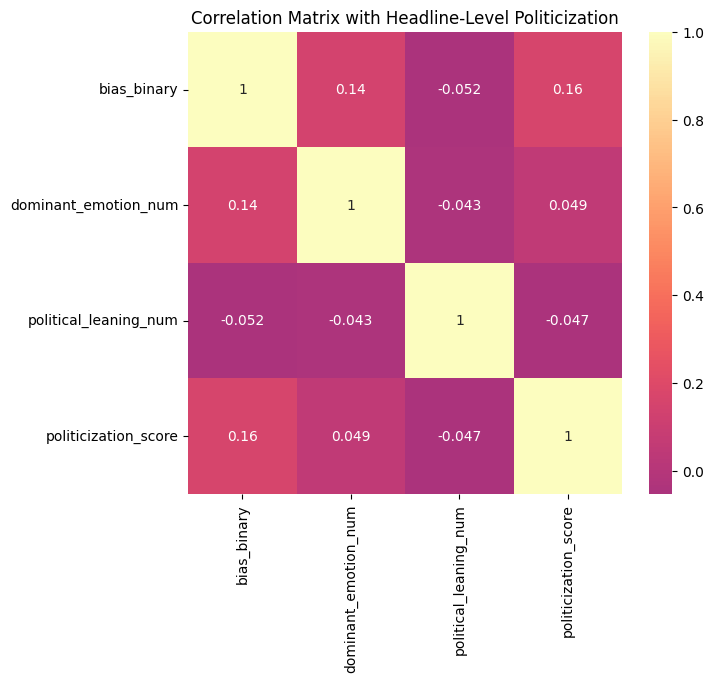

In [ ]:
features = df_combined[[
    "bias_binary",
    "dominant_emotion_num",
    "political_leaning_num",
    "politicization_score"
]]

corr_matrix = features.corr()
plt.figure(figsize=(7,6))
sns.heatmap(corr_matrix, annot=True, cmap="magma", center=0)
plt.title("Correlation Matrix with Headline-Level Politicization")
plt.show()

### 8.2 Chi-Square test

The Chi-Square test evaluates whether two categorical variables are statistically dependent. We applied the Chi-Square test to assess whether features such as bias, dominant emotion, political leaning and politicization score are significantly associated.

This approach helped uncover hidden dependencies that may have been missed by linear metrics and informed feature selection for classification tasks.

The results reveal highly significant associations:
- **Bias vs Emotion**: χ² = 5391.80, p < 0.001  
- **Bias vs Political Leaning**: χ² = 273.94, p < 0.001  
- **Emotion vs Political Leaning**: χ² = 1358.70, p < 0.001
- **Bias vs Politicization Score**: χ² = 4357.11, p < 0.0001
- **Emotion vs Politicization Score**: χ² = 4962.69, p < 0.0001
- **Political Leaning vs Politicization Score**: χ² = 562.15, p < 0.0001


These results suggest that **emotional tone**, **political leaning**, and **politicization score** are significantly associated with perceived bias. Each variable contributes distinct signals, suggesting that bias perception emerges from the interplay of affective, ideological, and rhetorical framing rather than from any single factor alone.


In [ ]:
# Bias vs Emotion
contingency_emotion = pd.crosstab(df_combined["bias_binary"], df_combined["dominant_emotion"])
chi2_emotion, p_emotion, _, _ = chi2_contingency(contingency_emotion)

# Bias vs Political Leaning
contingency_political = pd.crosstab(df_combined["bias_binary"], df_combined["political_leaning"])
chi2_political, p_political, _, _ = chi2_contingency(contingency_political)

# Emotion vs Political Leaning
contingency_emotion_political = pd.crosstab(df_combined["dominant_emotion"], df_combined["political_leaning"])
chi2_emotion_political, p_emotion_political, _, _ = chi2_contingency(contingency_emotion_political)

# Bias vs Politicization Score
# Categorize politicization_score into bins for Chi-Square test
df_combined["politicization_score_binned"] = pd.qcut(df_combined["politicization_score"], q=4, labels=False, duplicates='drop')

contingency_politicization = pd.crosstab(df_combined["bias_binary"], df_combined["politicization_score_binned"])
chi2_politicization, p_politicization, _, _ = chi2_contingency(contingency_politicization)

# Emotion vs Politicization Score
contingency_emotion_politicization = pd.crosstab(df_combined["dominant_emotion"], df_combined["politicization_score_binned"])
chi2_emotion_politicization, p_emotion_politicization, _, _ = chi2_contingency(contingency_emotion_politicization)

# Political Leaning vs Politicization Score
contingency_political_politicization = pd.crosstab(df_combined["political_leaning"], df_combined["politicization_score_binned"])
chi2_political_politicization, p_political_politicization, _, _ = chi2_contingency(contingency_political_politicization)


# Print results
print(f"Bias vs Emotion: Chi² = {chi2_emotion:.2f}, p = {p_emotion:.4f}")
print(f"Bias vs Political Leaning: Chi² = {chi2_political:.2f}, p = {p_political:.4f}")
print(f"Emotion vs Political Leaning: Chi² = {chi2_emotion_political:.2f}, p = {p_emotion_political:.4f}")
print(f"Bias vs Politicization Score: Chi² = {chi2_politicization:.2f}, p = {p_politicization:.4f}")
print(f"Emotion vs Politicization Score: Chi² = {chi2_emotion_politicization:.2f}, p = {p_emotion_politicization:.4f}")
print(f"Political Leaning vs Politicization Score: Chi² = {chi2_political_politicization:.2f}, p = {p_political_politicization:.4f}")

Bias vs Emotion: Chi² = 5391.80, p = 0.0000
Bias vs Political Leaning: Chi² = 273.94, p = 0.0000
Emotion vs Political Leaning: Chi² = 1358.70, p = 0.0000
Bias vs Politicization Score: Chi² = 4357.11, p = 0.0000
Emotion vs Politicization Score: Chi² = 4962.69, p = 0.0000
Political Leaning vs Politicization Score: Chi² = 562.15, p = 0.0000


## 11. DeBERTa-v3 Bias Classifier with Statified K Fold Cross Validation

Building on these findings, we fine-tuned the `microsoft/deberta-v3-base` classifier, consistent with the configuration employed in the text-only baseline model.

As in the previous model training, we applied **Stratified K-Fold Cross Validation** to ensure robust evaluation while preserving class distribution across folds.

The classifier was trained on an **extended feature set** consisting of raw headline text, emotion scores, and predicted political leaning. The feature-enhanced model used a **fusion architecture** that combined the transformer's [CLS] embedding with emotion and political leaning features to jointly model semantic and contextual signals.

We derived a new target label `label_direction`, which distinguished between biased headlines by their predicted leaning (`left`, `center`, `right`) and labels unbiased ones as `unbiased`. This categorical label was then encoded numerically (`label_encoded`).

**Evaluation metrics** included accuracy, precision, recall, and F1-score macro, consistent with the baseline setup.

This approach enabled a reliable performance assessment and supported a more nuanced modeling of bias by incorporating affective and ideological signals into the classification pipeline.

### 11.1 Feature Engineering: Emotion and Political Leaning

To enrich the feature space, we included **emotion scores** and predicted **political leaning** indicators for each headline. Emotion scores (`anger`, `disgust`, `fear`, etc.) captured affective framing, while leaning labels (`LABEL_left`, `LABEL_right`, etc.) reflected ideological cues.

These features supported **multi-class classification** and enabled a more nuanced analysis of rhetorical bias by bridging emotional framing and ideological orientation.

In [ ]:
# Including emotion and political leaning scores as additional features
emotion_cols = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
leaning_cols = ["left_score", "center_score", "right_score"]
feature_cols = emotion_cols + leaning_cols

df_combined["label_direction"] = df_combined.apply(
    lambda x: x["political_leaning"] if x["bias_binary"] == 1 else "unbiased", axis=1
)
label_encoder = LabelEncoder()
# Alphabetical order: center = 0, left = 1, right = 2, unbiased = 3
df_combined["label_encoded"] = label_encoder.fit_transform(df_combined["label_direction"])

### 11.2 Feature-enhanced model training

In [ ]:
# Reduce dataset to 50% for faster testing due to memory issues
df_sampled = df_combined.sample(frac=0.5, random_state=42).reset_index(drop=True)

In [ ]:
# Select balanced dataset
texts = df_sampled["text"].tolist()
labels = df_sampled["label_encoded"].tolist()
features = df_sampled[feature_cols].values.tolist()

In [ ]:
# Stratified K-Fold setup
set_seed(42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-base")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

In [ ]:
# Custom Dataset class
class BiasDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, features):
        self.encodings = encodings
        self.labels = labels
        self.features = features
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["features"] = torch.tensor(self.features[idx], dtype=torch.float)
        return item

In [ ]:
# Metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = np.argmax(probs, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "recall_macro": recall_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
        "recall_weighted": recall_score(labels, preds, average="weighted"),
        "precision_weighted": precision_score(labels, preds, average="weighted")
    }

In [ ]:
# Free up GPU memory
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import torch.nn as nn
from transformers import DebertaV2Model

In [ ]:
class FeatureFusionClassifier(nn.Module):
    def __init__(self, base_model_name, feature_dim, num_labels):
        super().__init__()
        self.transformer = DebertaV2Model.from_pretrained(base_model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.transformer.config.hidden_size + feature_dim, num_labels)

    def forward(self, input_ids, attention_mask, features, labels=None):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        fused = torch.cat([cls_embedding, features], dim=1)
        fused = self.dropout(fused)
        logits = self.classifier(fused)
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

In [ ]:
class FeatureTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        features = inputs.pop("features")
        outputs = model(**inputs, features=features, labels=labels)
        loss = outputs["loss"]
        return (loss, outputs) if return_outputs else loss

In [ ]:
# Cross-validation loop
all_metrics = []
all_preds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels), start=1):
    print(f"\n===== Fold {fold} =====")

    # Split data
    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]
    train_features = [features[i] for i in train_idx]
    val_features = [features[i] for i in val_idx]

    # Tokenize
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

    # Datasets
    train_dataset = BiasDataset(train_encodings, train_labels, train_features)
    val_dataset = BiasDataset(val_encodings, val_labels, val_features)

    # Model
    model = FeatureFusionClassifier(
        base_model_name="microsoft/deberta-v3-base",
        feature_dim=len(feature_cols),
        num_labels=len(label_encoder.classes_)
    )

    # Training setup
    output_dir = f"./results/fold{fold}"
    os.makedirs(output_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=4,
        fp16=True,
        eval_strategy="epoch",
        logging_dir=f"./logs/fold{fold}",
        logging_steps=10,
        save_strategy="epoch",
        save_total_limit=2,
        learning_rate=1e-5,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none"
    )

    # Trainer
    trainer = FeatureTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )

    # Train and evaluate
    trainer.train()
    metrics = trainer.evaluate()
    print(f"\nFold {fold} metrics:")
    print(metrics)
    all_metrics.append(metrics)

    # Save metrics for this fold
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(f"{output_dir}/metrics.csv", index=False)

    # Predictions
    preds_output = trainer.predict(val_dataset)
    logits = preds_output.predictions
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = np.argmax(logits, axis=-1)

    fold_df = pd.DataFrame({
        "text": val_texts,
        "true_label": val_labels,
        "predicted_label": preds.tolist(),
        "probabilities": probs.tolist()
    })
    fold_df.to_csv(f"{output_dir}/predictions.csv", index=False)
    all_preds.append(fold_df)


===== Fold 1 =====


/tmp/ipython-input-1484711478.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FeatureTrainer.__init__`. Use `processing_class` instead.
  trainer = FeatureTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Recall Macro,Precision Macro,F1 Weighted,Recall Weighted,Precision Weighted
1,0.835400,0.785313,0.679458,0.362831,0.393989,0.460161,0.624515,0.679458,0.645967
2,0.742000,0.767358,0.691196,0.418353,0.423444,0.454322,0.660633,0.691196,0.655899
3,0.665900,0.771756,0.690745,0.416868,0.423091,0.460134,0.659854,0.690745,0.659345


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


Fold 1 metrics:
{'eval_loss': 0.7673577666282654, 'eval_accuracy': 0.691196388261851, 'eval_f1_macro': 0.418352640073669, 'eval_recall_macro': 0.42344385373117166, 'eval_precision_macro': 0.45432182138796806, 'eval_f1_weighted': 0.6606329289432915, 'eval_recall_weighted': 0.691196388261851, 'eval_precision_weighted': 0.6558989660081906, 'eval_runtime': 88.4848, 'eval_samples_per_second': 50.065, 'eval_steps_per_second': 6.261, 'epoch': 3.0}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


===== Fold 2 =====


/tmp/ipython-input-1484711478.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FeatureTrainer.__init__`. Use `processing_class` instead.
  trainer = FeatureTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Recall Macro,Precision Macro,F1 Weighted,Recall Weighted,Precision Weighted
1,0.720700,0.789187,0.672460,0.366952,0.393860,0.432892,0.622698,0.672460,0.628947
2,0.763400,0.760436,0.681490,0.404339,0.410936,0.443838,0.646146,0.681490,0.641886
3,0.716300,0.772602,0.685102,0.412466,0.419469,0.446250,0.654719,0.685102,0.649718


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


Fold 2 metrics:
{'eval_loss': 0.7726019024848938, 'eval_accuracy': 0.6851015801354402, 'eval_f1_macro': 0.41246648119256313, 'eval_recall_macro': 0.41946887619803314, 'eval_precision_macro': 0.4462498067173184, 'eval_f1_weighted': 0.6547193548763935, 'eval_recall_weighted': 0.6851015801354402, 'eval_precision_weighted': 0.6497175200965014, 'eval_runtime': 88.6005, 'eval_samples_per_second': 50.0, 'eval_steps_per_second': 6.253, 'epoch': 3.0}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


===== Fold 3 =====


/tmp/ipython-input-1484711478.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FeatureTrainer.__init__`. Use `processing_class` instead.
  trainer = FeatureTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Recall Macro,Precision Macro,F1 Weighted,Recall Weighted,Precision Weighted
1,0.816900,0.775333,0.677652,0.366633,0.393323,0.446550,0.624180,0.677652,0.636053
2,0.709800,0.759964,0.685553,0.411385,0.419615,0.448231,0.654588,0.685553,0.651605
3,0.708800,0.762588,0.693002,0.423908,0.427340,0.466675,0.663500,0.693002,0.662528


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


Fold 3 metrics:
{'eval_loss': 0.7625882029533386, 'eval_accuracy': 0.6930022573363431, 'eval_f1_macro': 0.42390762384594105, 'eval_recall_macro': 0.4273398371672371, 'eval_precision_macro': 0.46667487466196966, 'eval_f1_weighted': 0.6634999443080729, 'eval_recall_weighted': 0.6930022573363431, 'eval_precision_weighted': 0.6625277376936306, 'eval_runtime': 88.539, 'eval_samples_per_second': 50.034, 'eval_steps_per_second': 6.257, 'epoch': 3.0}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


===== Fold 4 =====


/tmp/ipython-input-1484711478.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FeatureTrainer.__init__`. Use `processing_class` instead.
  trainer = FeatureTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Recall Macro,Precision Macro,F1 Weighted,Recall Weighted,Precision Weighted
1,0.762500,0.804734,0.672235,0.370365,0.391877,0.431795,0.622429,0.672235,0.625525
2,0.836100,0.774471,0.681716,0.401474,0.409188,0.464066,0.643221,0.681716,0.649964
3,0.671800,0.776163,0.688036,0.432812,0.431118,0.470138,0.663123,0.688036,0.661027


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


Fold 4 metrics:
{'eval_loss': 0.7761631608009338, 'eval_accuracy': 0.6880361173814898, 'eval_f1_macro': 0.4328117680382608, 'eval_recall_macro': 0.43111812402943595, 'eval_precision_macro': 0.4701377970768552, 'eval_f1_weighted': 0.6631234950691424, 'eval_recall_weighted': 0.6880361173814898, 'eval_precision_weighted': 0.6610272297146604, 'eval_runtime': 89.1793, 'eval_samples_per_second': 49.675, 'eval_steps_per_second': 6.212, 'epoch': 3.0}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


===== Fold 5 =====


/tmp/ipython-input-1484711478.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FeatureTrainer.__init__`. Use `processing_class` instead.
  trainer = FeatureTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Recall Macro,Precision Macro,F1 Weighted,Recall Weighted,Precision Weighted
1,0.800800,0.780638,0.683521,0.365355,0.393994,0.504609,0.626393,0.683521,0.670158
2,0.719200,0.748001,0.694131,0.406582,0.419257,0.469360,0.656525,0.694131,0.664447
3,0.724700,0.750248,0.701806,0.436798,0.437602,0.476752,0.675124,0.701806,0.673698


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


Fold 5 metrics:
{'eval_loss': 0.7502475380897522, 'eval_accuracy': 0.701805869074492, 'eval_f1_macro': 0.43679757911163564, 'eval_recall_macro': 0.4376017160279857, 'eval_precision_macro': 0.4767521576562054, 'eval_f1_weighted': 0.6751238461928624, 'eval_recall_weighted': 0.701805869074492, 'eval_precision_weighted': 0.6736984455017935, 'eval_runtime': 88.9143, 'eval_samples_per_second': 49.823, 'eval_steps_per_second': 6.231, 'epoch': 3.0}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
# Save all metrics across folds
all_metrics_df = pd.DataFrame(all_metrics)
all_metrics_df.to_csv("./results/all_fold_metrics_withfeatures.csv", index=False)

# Combine all predictions
all_preds_df = pd.concat(all_preds, ignore_index=True)
all_preds_df.to_csv("./results/all_predictions_withfeatures.csv", index=False)

### 11.3 Evaluation of feature-enhanced model

The feature-enhanced model showed consistent performance across all five folds, with accuracy ranging from **68.5%** to **70.2%** and macro F1 scores between **0.41** and **0.44**. Precision remained slightly higher than recall, indicating cautious classification behavior. While the model did not outperform the text-only baseline, it maintained stable convergence and supports interpretability in bias detection through the integration of emotion and political leaning features.

## 12. Evaluation and Performance comparison: Text-only Model vs. Feature-Enhanced Model

This section showed a comparative evaluation of the text-only and feature-enhanced models. For each, we computed the **mean** and **standard deviation** of key metrics (`eval_accuracy`, `eval_f1`, `eval_precision`, `eval_recall`, and `eval_loss`), aggregated across five cross-validation folds.

We first retrieved the CSV files produced during training, each containing key performance metrics. These were parsed into dataframes for systematic analysis.


In [ ]:
# Load csv of model without additional features
df_without = pd.read_csv("/content/all_fold_metrics_nofeatures.csv")
# If you load the file directly from the local folder after creating the csv:
# df_without = pd.read_csv("content/results/all_fold_metrics_nofeatures.csv")

In [ ]:
# Calculate mean values and standard deviations
metrics = ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall", "eval_loss"]

# Mean
mean_values = df_without[metrics].mean()

# Standard derivation
std_values = df_without[metrics].std()

# Output
print("Mean:")
print(mean_values.round(4))

print("\nStandard deviation:")
print(std_values.round(4))

Mean:
eval_accuracy     0.8355
eval_f1           0.8355
eval_precision    0.8358
eval_recall       0.8356
eval_loss         0.4739
dtype: float64

Standard deviation:
eval_accuracy     0.0021
eval_f1           0.0021
eval_precision    0.0022
eval_recall       0.0021
eval_loss         0.0100
dtype: float64


In [ ]:
# Load csv of model without additional features
# df_with = pd.read_csv("/content/all_fold_metrics_withfeatures.csv")
# If you load the file directly from the local folder after creating the csv:
df_with = pd.read_csv("/content/results/all_fold_metrics_withfeatures.csv")

In [ ]:
# Calculate mean values and standard deviations
metrics = ["eval_accuracy", "eval_f1_macro", "eval_precision_macro", "eval_recall_macro", "eval_loss"]

# Mean
mean_values = df_with[metrics].mean()

# Standard derivation
std_values = df_with[metrics].std()

# Output
print("Mean:")
print(mean_values.round(4))

print("\nStandard deviation:")
print(std_values.round(4))

Mean:
eval_accuracy           0.6918
eval_f1_macro           0.4249
eval_precision_macro    0.4628
eval_recall_macro       0.4278
eval_loss               0.7658
dtype: float64

Standard deviation:
eval_accuracy           0.0063
eval_f1_macro           0.0100
eval_precision_macro    0.0123
eval_recall_macro       0.0070
eval_loss               0.0101
dtype: float64


### Performance Comparison: Text-only Model vs. Feature-Enhanced Model

The following table depicts the combined results from the text-only model and the feature-enhanced model:

| Metric             | Text-only Mean | Feature-enhanced Mean | Text-only Std | Feature-enhanced Std |
|--------------------|----------------|------------------------|----------------|-----------------------|
| Accuracy           | 0.8355         | 0.6918                 | 0.0021         | 0.0063                |
| F1 Score (Macro)   | 0.8355         | 0.4249                 | 0.0021         | 0.0100                |
| Precision (Macro)  | 0.8358         | 0.4628                 | 0.0022         | 0.0123                |
| Recall (Macro)     | 0.8356         | 0.4278                 | 0.0021         | 0.0070                |
| Eval Loss          | 0.4739         | 0.7658                 | 0.0100         | 0.0101                |


The **feature-enhanced model** achieved moderate performance across folds, but did not outperform the text-only baseline. While its precision was slightly higher on average, the overall accuracy and macro F1 scores remained lower, and the model exhibited greater variance across folds.

In contrast, the **text-only model** demonstrated consistently strong results, with lower evaluation loss and minimal deviation across folds—indicating stable convergence and reliable generalization. These findings suggest that headline text alone provides a robust signal for rhetorical bias classification.

This comparison highlights that while **auxiliary features** such as emotional tone and political leaning may enrich interpretability, they do not consistently improve predictive performance.

